# Обработаем данные

In [1]:
import pandas as pd

import numpy as np

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [2]:
pd.set_option('display.max_columns', None)

In [160]:
import sys
import os

 
notebook_dir = os.getcwd() 
 
modules_path = os.path.join(notebook_dir, "modules")
 
# 1) Проверяем, если папка modules на одном уровне с notebook
if not os.path.isdir(modules_path):
    # 2) Если нет, проверяем на уровень выше
    modules_path = os.path.join(notebook_dir, "..", "modules")
 
# Добавляем в sys.path
if os.path.isdir(modules_path):
    sys.path.append(os.path.abspath(modules_path))
else:
    raise FileNotFoundError("Папка 'modules' не найдена ни на текущем уровне, ни на уровне выше.")

In [49]:
train_test = pd.read_parquet("/data/churn_space/egbatari/parquets/yota_3m_features_preprocessed_train_val_baseline1.4.parquet")

In [50]:
drop_column = ['STATUS_PYRAMID_3M_MONTH_1', 'STATUS_PYRAMID_3M_MONTH_2', 'STATUS_PYRAMID_3M_MONTH_3',
              'STATUS_PYRAMID_1M_MONTH_1', 'STATUS_PYRAMID_1M_MONTH_2', 'STATUS_PYRAMID_1M_MONTH_3',
               'STATUS_PYRAMID_3M_MONTH_1_flag', 'STATUS_PYRAMID_3M_MONTH_2_flag', 'STATUS_PYRAMID_3M_MONTH_3_flag',
              'STATUS_PYRAMID_1M_MONTH_1_flag', 'STATUS_PYRAMID_1M_MONTH_2_flag', 'STATUS_PYRAMID_1M_MONTH_3_flag',
               '1m_streak_1', '1m_streak_0', '1m_switches', '3m_streak_1', '3m_streak_0', '3m_switches'
              ]

In [51]:
train_test = train_test.drop(columns = drop_column)

In [52]:
categ_features = [col for col in train_test.select_dtypes(include = ['object']).columns]

In [53]:
categ_features

[]

In [54]:
train_test['SNAP_DATE'] = pd.to_datetime(train_test['SNAP_DATE'])

# Извлечение года и месяца
train_test['year'] = train_test['SNAP_DATE'].dt.year
train_test['month'] = train_test['SNAP_DATE'].dt.month

# Вычисление значения snap_time
conditions = [
    (train_test['year'] == 2024),
    (train_test['year'] == 2025)
]
choices = [
    train_test['month'],
    train_test['month'] + 12
]

train_test['snap_time'] = pd.np.select(conditions, choices)
train_test['target_time'] = train_test['snap_time'] + 1

train_test = train_test.drop(columns = ['year', 'month'])

/data/churn_space/egbatari/custom-envs/egbatarienv/lib64/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [55]:
train_test

,SK_SUBS_ID,SNAP_DATE,FILIAL_ID,TARGET,subs_age_overprice,max_overp_to_ap_6,cnt_mou_3,vas_2nd,vas_2_3,max_vas_to_ap_2,max_vas_to_ap_3,revenue_vas_1m_to_ap,revenue_vas_2m_to_ap,revenue_vas_3m_to_ap,price_mou_2_to_ap,price_mc_2_to_ap,price_dou_2_to_ap,price_mou_dou_2_to_ap,price_sms_2_to_ap,price_abc_2_to_ap,revenue_wo_vas_roam_s1,revenue_wo_vas_roam_s4,revenue_wo_roam_s1,revenue_wo_roam_s4,revenue_s1,revenue_s4,pay_amount_r_s1,pay_amount_r_s2,pay_amount_r_s4,pay_amount_r_s8,pay_amount_r_s12,pay_amount_r_max2,pay_amount_r_max4,pay_amount_r_max6,dou_roaming_4g_s8,dou_4g_max8,dou_4g_max12,dou_4g_min12,dou_min4,dou_min8,dou_min12,dou_roaming_4g_min4,dou_roaming_4g_min8,mou_roaming_s1,mou_roaming_s8,mou_min4,mou_min12,mou_out_min12,mou_roaming_min4,call_dur_in_fav_max_rate_1,call_dur_in_fav_min_rate4,call_in_cnt_fav_min_rate4,call_in_cnt_fav1_ratep4,call_out_cnt_fav_min_rate_1,data_wknd_day_rate,data_wrkd_day_rate,data_dur_s1,data_megaroam_4g_dur_s1,data_megaroam_dur_s1,data_wrkd_rate_1,fav_count,fav_megafon_rate,offnet_s1,sms_cnt_wrkd_rate,voice_wknd_day_rate,voice_megaroam_out_cnt_s1,voice_megaroam_out_dur_s1,time_in_fb_s1,time_in_fb_s2,time_in_fb_s4,time_in_fb_s6,pay_count_s2,pay_count_s6,pay_count_s8,pay_count_s12,balance_on_fb_a4,cart_voice_rtpl_max,pay_lag_days_a24,lifetime_overprice_udm,days_active,credit_usage,subs_age_udm_top,actual_balance,virt_pay_amount_s4,virt_pay_days_s4,last_transact_wo_sn_status_date,clnt_lifetime,prev_monday_bigint,lifetime_subs_churn,last_charges_date,last_paym_date_subs_churn,last_rm_voice_out_date,last_voice_out_mgmn_date,amount_ratio,vas_ratio_chng,arpu_diff,mou_m3,mou_last_amount_lift,sf_last_amount_lift,last_amount_lift,mou_amount_lift,sf_amount_lift,wo_sf_amount_lift,core_amount_lift,device_avg_lifetime,stop_loc_ctn,stop_loc_uniq_ctn,avg_stop_loc_time_top1,subs_connect_date,debet_bal_s30,revenue_wo_itc_vas_roam4,churn_score_udm,REVENUE_CORE_1M,REVENUE_CORE_2M,REVENUE_CORE_3M,ABON_PLATA_CLEAR,BALANCE_AMOUNT,snap_time,target_time
0,474143246,2024-09-01,1,0.0,3654.0,0.961706,1.0,150.0,571.0,2.931143,2.931143,2.931143,1.749602,1.266760,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,7.500000,309.380005,7.500000,730.380005,7.500000,730.380005,0.0,0.0,0.0,400.0,800.0,0.0,0.0,400.0,0.000000,31782.935547,31782.935547,11377.676758,22484.500000,12802.283203,11473.216797,0.0,0.0,0.000000,0.000000,21.283331,14.700002,5.900002,0.0,0.630000,0.04,0.11,0.59,0.04000,0.53,0.23,31791.455078,0.000000,0.000000,0.78,5.0,0.2,2.250001,0.93,0.10,0.0,0.000000,534125.0,580235.0,580235.0,1155737.0,0.0,1.0,1.0,2.0,546.820007,0.000000,14.444445,3641.251465,7.0,7.0,3641.0,702.270020,2100.000000,4.000000,1.723928e+09,308.0,1.723410e+09,3634.251505,22,47,374247,374247,2.051817,0.635201,0.500779,175.183336,0.134352,0.134352,0.333695,0.413622,0.623421,0.623421,0.124568,57.600000,36.0,15.0,1683.925000,3655,856.40,192.47,0.008152,309.37,192.47,202.59,162.700000,641.27,9,10
1,474200341,2024-04-01,1,0.0,3487.0,-2.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,471.670013,0.000000,471.670013,0.000000,471.670013,0.0,0.0,1132.0,1132.0,3132.0,0.0,566.0,566.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.383367,0.00,0.00,0.00,0.28401,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.89,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.000000,0.000000,30.000000,3479.992432,0.0,0.0,3480.0,-1826.000000,955.687937,0.938212,1.709240e+09,3129.0,1.710709e+09,3472.992419,31,32,83,374094,1.000000,0.000000,0.000000,0.000000,0.966262,0.966262,0.886171,-0.301843,-0.370912,-0.370912,-0.301843,148.562399,0.0,0.0,0.000000,3487,566.00,455.94,0.008424,487.39,455.94,632.39,566.000000,-1826.00,4,5
2,474344253,2024-05-01,1,1.0,3473.0,-2.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [98]:
duration_index_times = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0]

In [63]:
df_train = train_test
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [64]:
X_test = df_test.drop(columns = ['FILIAL_ID','SK_SUBS_ID','SNAP_DATE','TARGET' , 'snap_time', 'target_time'])
y_test_target = df_test['TARGET']
y_test_time = df_test['target_time']

X_train = df_train.drop(columns = ['FILIAL_ID','SK_SUBS_ID','SNAP_DATE','TARGET' , 'snap_time', 'target_time'])
y_train_target = df_train['TARGET']
y_train_time = df_train['target_time']

X_val = df_val.drop(columns = ['FILIAL_ID','SK_SUBS_ID','SNAP_DATE','TARGET' , 'snap_time', 'target_time'])
y_val_target = df_val['TARGET']
y_val_time = df_val['target_time']


In [80]:
y_test = (y_test_time.values, y_test_target.values)
y_train = (y_train_time.values, y_train_target.values)
y_val = (y_val_time.values, y_val_target.values)

In [68]:
standardize = [([col], StandardScaler()) for col in X_train.columns]

x_mapper = DataFrameMapper(standardize)

In [69]:
x_train_standardize = x_mapper.fit_transform(X_train).astype('float32')
x_val_standardize = x_mapper.transform(X_val).astype('float32')
x_test_standardize = x_mapper.transform(X_test).astype('float32')

In [84]:
train = (x_train_standardize, y_train)
val = (x_val_standardize, y_val)

# Обучаем и скорим DeepHit 

In [99]:
len(duration_index_times)

13

In [100]:
in_features = x_train_standardize.shape[1]
num_nodes = [32, 32]
out_features = len(duration_index_times)
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [239]:
model_deephit = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=duration_index_times)

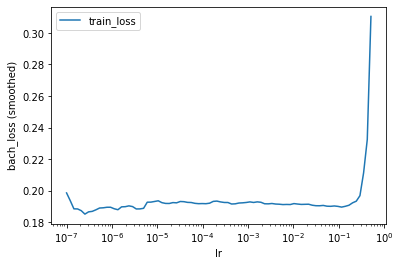

In [240]:
batch_size = 256
lr_finder = model.lr_finder(x_train_standardize, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [242]:
lr_finder.get_best_lr()

0.0001

In [243]:
model_deephit.optimizer.set_lr(0.01)

In [ ]:
%%time

epochs = 50
callbacks = [tt.callbacks.EarlyStopping()]
log = model_deephit.fit(x_train_standardize, y_train, batch_size, epochs, callbacks, val_data=val)

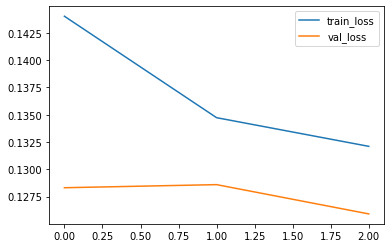

In [245]:
_ = log.plot()

In [246]:
%%time

surv = model_deephit.predict_surv_df(x_test_standardize)

CPU times: user 1min 16s, sys: 12.7 s, total: 1min 29s
Wall time: 1.94 s


Таргет = 1.0, время таргета = 5


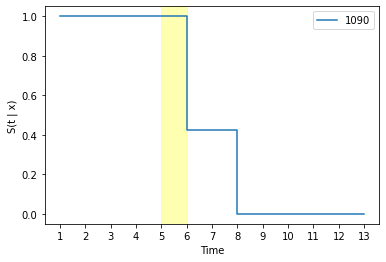

In [268]:
index = 1090

surv.iloc[:, index:index + 1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

plt.xticks(duration_index_times)
plt.axvspan(y_test[0][index], y_test[0][index] + 1, color='yellow', alpha=0.3)

print(f"Таргет = {y_test[1][index]}, время таргета = {y_test[0][index]}")


In [249]:
%%time

pred_proba_deephit = []

for index in range(surv.shape[1]):
    pred_0 = surv[index][y_test[0][index]+1]
    pred_1 = 1 - pred_0
    pred_proba_deephit.append([pred_0, pred_1])

CPU times: user 38 s, sys: 1.69 s, total: 39.7 s
Wall time: 39.6 s


In [250]:
%%time

from scoring import reports

target = {0:0,
          1:1}

models_d = {'deephit':0}

perc = [0.5, 1, 2, 3, 4, 5, 10, 20,25, 30, 40, 50, 60, 70, 80, 90, 100]

final_full_deephit = reports(target, models_d, perc, pd.DataFrame(pred_proba_deephit), pd.DataFrame(y_test[1]))

CPU times: user 47.3 s, sys: 1.42 s, total: 48.7 s
Wall time: 48.7 s


# Обучаем и скорим  Catboost

In [202]:
from catboost import CatBoostClassifier, Pool
import optuna
import catboost as cb
from sklearn.metrics import mean_squared_error

In [208]:
X_train

,subs_age_overprice,max_overp_to_ap_6,cnt_mou_3,vas_2nd,vas_2_3,max_vas_to_ap_2,max_vas_to_ap_3,revenue_vas_1m_to_ap,revenue_vas_2m_to_ap,revenue_vas_3m_to_ap,price_mou_2_to_ap,price_mc_2_to_ap,price_dou_2_to_ap,price_mou_dou_2_to_ap,price_sms_2_to_ap,price_abc_2_to_ap,revenue_wo_vas_roam_s1,revenue_wo_vas_roam_s4,revenue_wo_roam_s1,revenue_wo_roam_s4,revenue_s1,revenue_s4,pay_amount_r_s1,pay_amount_r_s2,pay_amount_r_s4,pay_amount_r_s8,pay_amount_r_s12,pay_amount_r_max2,pay_amount_r_max4,pay_amount_r_max6,dou_roaming_4g_s8,dou_4g_max8,dou_4g_max12,dou_4g_min12,dou_min4,dou_min8,dou_min12,dou_roaming_4g_min4,dou_roaming_4g_min8,mou_roaming_s1,mou_roaming_s8,mou_min4,mou_min12,mou_out_min12,mou_roaming_min4,call_dur_in_fav_max_rate_1,call_dur_in_fav_min_rate4,call_in_cnt_fav_min_rate4,call_in_cnt_fav1_ratep4,call_out_cnt_fav_min_rate_1,data_wknd_day_rate,data_wrkd_day_rate,data_dur_s1,data_megaroam_4g_dur_s1,data_megaroam_dur_s1,data_wrkd_rate_1,fav_count,fav_megafon_rate,offnet_s1,sms_cnt_wrkd_rate,voice_wknd_day_rate,voice_megaroam_out_cnt_s1,voice_megaroam_out_dur_s1,time_in_fb_s1,time_in_fb_s2,time_in_fb_s4,time_in_fb_s6,pay_count_s2,pay_count_s6,pay_count_s8,pay_count_s12,balance_on_fb_a4,cart_voice_rtpl_max,pay_lag_days_a24,lifetime_overprice_udm,days_active,credit_usage,subs_age_udm_top,actual_balance,virt_pay_amount_s4,virt_pay_days_s4,last_transact_wo_sn_status_date,clnt_lifetime,prev_monday_bigint,lifetime_subs_churn,last_charges_date,last_paym_date_subs_churn,last_rm_voice_out_date,last_voice_out_mgmn_date,amount_ratio,vas_ratio_chng,arpu_diff,mou_m3,mou_last_amount_lift,sf_last_amount_lift,last_amount_lift,mou_amount_lift,sf_amount_lift,wo_sf_amount_lift,core_amount_lift,device_avg_lifetime,stop_loc_ctn,stop_loc_uniq_ctn,avg_stop_loc_time_top1,subs_connect_date,debet_bal_s30,revenue_wo_itc_vas_roam4,churn_score_udm,REVENUE_CORE_1M,REVENUE_CORE_2M,REVENUE_CORE_3M,ABON_PLATA_CLEAR,BALANCE_AMOUNT
3,3472.0,0.221625,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,192.929993,341.000000,192.929993,341.000000,192.929993,341.000000,396.0,396.0,396.00000,792.000000,1188.000000,396.0,396.00000,396.00000,5980.292969,5595.059570,5595.059570,193.839844,209.056641,209.056641,209.056641,0.000000,0.000000,0.333333,0.333333,1.300001,0.483334,0.316667,0.000000,0.000000,0.00,0.00,0.00,0.50000,0.63,0.36,209.056641,5980.292969,6038.052734,1.00,1.0,0.0,6.066667,0.99,0.50,1.0,0.133333,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.00000,192.929993,30.000000,3460.119629,7.0,3.0,3460.0,0.000000,955.687937,0.938212,1.716066e+09,3459.0,1.715548e+09,3453.119664,31,48,162,374155,0.448697,0.000000,-0.551303,21.816668,0.813851,0.813851,0.813851,-0.408382,-0.408382,-0.408382,-0.408382,141.000000,18.0,3.0,807.496667,3473,396.00,330.00,0.003628,341.00,330.00,341.00,396.000000,0.00
5,3443.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,306.540009,0.000000,306.540009,0.000000,306.540009,0.0,310.0,310.00000,680.000000,1040.000000,300.0,300.00000,370.00000,0.000000,11279.524414,12316.291992,1835.415039,3806.616211,3806.616211,3806.616211,0.000000,0.000000,0.000000,0.000000,31.733334,31.733334,9.883333,0.000000,0.700000,0.04,0.05,0.50,0.17000,0.89,0.85,12631.239258,0.000000,0.000000,0.37,2.0,0.5,54.266666,0.20,0.50,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,0.00000,0.000000,25.666666,3431.192383,7.0,0.0,3431.0,-12.000000,955.687937,0.938212,1.716066e+09,3430.0,1.715548e+09,3424.192338,24,20,374155,374155,1.033269,0.000000,0.033269,167.816667,0.340160,0.340160,0.340160,-0.097781,-0.097781,-0.097781,-0.097781,201.000000,28.0,14.0,4972.716667,3444,356.00,296.67,0.002009,306.54,296.67,306.52,356.000000,-12.00
8,3564.0,-2.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.670013,0.000000,277.670013,0.00

In [203]:
train_pool = Pool(X_train.values, y_train[1])
val_pool = Pool(X_val.values, y_val[1])


In [214]:
def objective(trial):
    params = {
        "iterations": 100,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
 
    model = cb.CatBoostClassifier(**params, silent=True)
    model.fit(train_pool, eval_set = val_pool, use_best_model = True, early_stopping_rounds = 100)
    predictions = model.predict(X_val.values)
    rmse = mean_squared_error(y_val[1], predictions, squared=False)
    return rmse
 



In [215]:
%%time

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)
 


[I 2025-03-19 21:36:24,726] A new study created in memory with name: no-name-413945db-3deb-458f-a052-dc9f16ecb4b8
[I 2025-03-19 21:37:19,679] Trial 0 finished with value: 0.42853090527354093 and parameters: {'learning_rate': 0.05843257787222207, 'depth': 8, 'subsample': 0.8501620591890029, 'colsample_bylevel': 0.8409241521603851, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.42853090527354093.
[I 2025-03-19 21:37:46,209] Trial 1 finished with value: 0.4451315066064235 and parameters: {'learning_rate': 0.009484298801173782, 'depth': 10, 'subsample': 0.11807518760309801, 'colsample_bylevel': 0.10152097574700758, 'min_data_in_leaf': 59}. Best is trial 0 with value: 0.42853090527354093.


CPU times: user 2h 41min 56s, sys: 9min 29s, total: 2h 51min 26s
Wall time: 1min 21s


In [251]:
%%time

best_params = study.best_params
 
# Меняем число итераций на 1000
best_params["iterations"] = 1000
best_params['logging_level'] = 'Verbose'
 
# Создаем и обучаем модель с лучшими параметрами
best_model = cb.CatBoostClassifier(**best_params)
best_model.fit(train_pool, eval_set = val_pool, use_best_model = True, early_stopping_rounds = 100)

0:	learn: 0.6625303	test: 0.6625560	best: 0.6625560 (0)	total: 435ms	remaining: 7m 14s
1:	learn: 0.6375377	test: 0.6376198	best: 0.6376198 (1)	total: 940ms	remaining: 7m 49s
2:	learn: 0.6152963	test: 0.6153957	best: 0.6153957 (2)	total: 1.48s	remaining: 8m 13s
3:	learn: 0.5959496	test: 0.5960542	best: 0.5960542 (3)	total: 2.05s	remaining: 8m 29s
4:	learn: 0.5784008	test: 0.5785133	best: 0.5785133 (4)	total: 2.57s	remaining: 8m 32s
5:	learn: 0.5636540	test: 0.5637905	best: 0.5637905 (5)	total: 3.23s	remaining: 8m 55s
6:	learn: 0.5507423	test: 0.5508970	best: 0.5508970 (6)	total: 3.77s	remaining: 8m 54s
7:	learn: 0.5396203	test: 0.5398081	best: 0.5398081 (7)	total: 4.48s	remaining: 9m 15s
8:	learn: 0.5293918	test: 0.5296009	best: 0.5296009 (8)	total: 5.09s	remaining: 9m 20s
9:	learn: 0.5200768	test: 0.5202636	best: 0.5202636 (9)	total: 5.73s	remaining: 9m 26s
10:	learn: 0.5113353	test: 0.5115156	best: 0.5115156 (10)	total: 6.25s	remaining: 9m 21s
11:	learn: 0.5042294	test: 0.5044515	best

In [252]:
pred_proba_catboost = best_model.predict_proba(X_test.values)

In [253]:
%%time

from scoring import reports

target = {0:0,
          1:1}

models_d = {'catboost':0}

perc = [0.5, 1, 2, 3, 4, 5, 10, 20,25, 30, 40, 50, 60, 70, 80, 90, 100]

final_full_catboost = reports(target, models_d, perc, pd.DataFrame(pred_proba_catboost), pd.DataFrame(y_test[1]))

CPU times: user 46.9 s, sys: 1.25 s, total: 48.1 s
Wall time: 48.1 s


# Сравнение моделей

#### DeepHit

In [254]:
with pd.option_context('float_format', "{:0<5,.3f}".format):
    display(final_full_deephit.loc[[1], 'deephit'])

metrics                precision  recall    f1  roc-auc  pr-auc       count  \
score date percentile                                                         
1          0.500           0.986   0.010 0.019    0.505   0.510   4,286.000   
           1.000           0.982   0.019 0.038    0.510   0.515   8,572.000   
           2.000           0.977   0.039 0.074    0.519   0.524  17,143.000   
           3.000           0.975   0.058 0.109    0.528   0.533  25,714.000   
           4.000           0.972   0.077 0.142    0.537   0.541  34,286.000   
           5.000           0.969   0.096 0.174    0.546   0.550  42,857.000   
           10.000          0.959   0.190 0.317    0.591   0.591  85,714.000   
           20.000          0.937   0.371 0.531    0.673   0.665 171,427.000   
           25.000          0.923   0.457 0.611    0.709   0.696 214,283.000   
           30.000          0.906   0.538 0.675    0.741   0.721 257,140.000   
           40.000          0.862   0.682 0.762    0.785   0.749 342,853.000   
           50.000          0.802   0.794 0.798    0.797   0.741 428,566.000   
           60.000          0.738   0.876 0.801    0.779   0.709 514,279.000   
           70.000          0.672   0.930 0.780    0.733   0.660 599,992.000   
           80.000          0.610   0.966 0.748    0.668   0.607 685,705.000   
           90.000          0.555   0.989 0.711    0.590   0.555 771,418.000   
           100.000         0.505   1.000 0.672    0.500   0.505 857,131.000   

metrics                proba        0_in        1_in  0_in_perc  1_in_perc  
score date percentile                                                       
1          0.500       0.881      62.000   4,224.000      0.014      0.986  
           1.000       0.864     152.000   8,420.000      0.018      0.982  
           2.000       0.846     390.000  16,753.000      0.023      0.977  
           3.000       0.833     650.000  25,064.000      0.025      0.975  
           4.000       0.821     974.000  33,312.000      0.028      0.972  
           5.000       0.811   1,330.000  41,527.000      0.031      0.969  
           10.000      0.770   3,555.000  82,159.000      0.041      0.959  
           20.000      0.708  10,788.000 160,639.000      0.063      0.937  
           25.000      0.677  16,471.000 197,812.000      0.077      0.923  
           30.000      0.647  24,046.000 233,094.000      0.094      0.906  
           40.000      0.586  47,346.000 295,507.000      0.138      0.862  
           50.000      0.528  84,653.000 343,913.000      0.198      0.802  
           60.000      0.476 134,942.000 379,337.000      0.262      0.738  
           70.000      0.427 196,924.000 403,068.000      0.328      0.672  
           80.000      0.379 267,240.000 418,465.000      0.390      0.610  
           90.000      0.323 343,130.000 428,288.000      0.445      0.555  
           100.000     0.000 423,880.000 433,251.000      0.495      0.505

#### CatBoost

In [255]:
with pd.option_context('float_format', "{:0<5,.3f}".format):
    display(final_full_catboost.loc[[1], 'catboost'])

metrics                precision  recall    f1  roc-auc  pr-auc       count  \
score date percentile                                                         
1          0.500           0.997   0.010 0.020    0.505   0.510   4,286.000   
           1.000           0.994   0.020 0.039    0.510   0.515   8,572.000   
           2.000           0.992   0.039 0.076    0.519   0.525  17,143.000   
           3.000           0.990   0.059 0.111    0.529   0.534  25,714.000   
           4.000           0.988   0.078 0.145    0.539   0.543  34,286.000   
           5.000           0.987   0.098 0.178    0.548   0.552  42,857.000   
           10.000          0.979   0.194 0.323    0.595   0.597  85,714.000   
           20.000          0.961   0.380 0.545    0.682   0.679 171,427.000   
           25.000          0.950   0.470 0.628    0.722   0.714 214,283.000   
           30.000          0.936   0.556 0.697    0.758   0.745 257,140.000   
           40.000          0.895   0.708 0.791    0.812   0.781 342,853.000   
           50.000          0.834   0.825 0.830    0.829   0.777 428,566.000   
           60.000          0.762   0.905 0.827    0.808   0.738 514,279.000   
           70.000          0.688   0.952 0.799    0.755   0.679 599,992.000   
           80.000          0.619   0.979 0.758    0.681   0.616 685,705.000   
           90.000          0.558   0.994 0.715    0.595   0.558 771,418.000   
           100.000         0.505   1.000 0.672    0.500   0.505 857,131.000   

metrics                proba        0_in        1_in  0_in_perc  1_in_perc  
score date percentile                                                       
1          0.500       0.994      15.000   4,271.000      0.003      0.997  
           1.000       0.990      54.000   8,518.000      0.006      0.994  
           2.000       0.986     136.000  17,007.000      0.008      0.992  
           3.000       0.982     256.000  25,458.000      0.010      0.990  
           4.000       0.979     408.000  33,878.000      0.012      0.988  
           5.000       0.976     556.000  42,301.000      0.013      0.987  
           10.000      0.960   1,842.000  83,872.000      0.021      0.979  
           20.000      0.918   6,637.000 164,790.000      0.039      0.961  
           25.000      0.883  10,818.000 203,465.000      0.050      0.950  
           30.000      0.834  16,444.000 240,696.000      0.064      0.936  
           40.000      0.676  35,971.000 306,882.000      0.105      0.895  
           50.000      0.485  71,085.000 357,481.000      0.166      0.834  
           60.000      0.315 122,242.000 392,037.000      0.238      0.762  
           70.000      0.189 187,341.000 412,651.000      0.312      0.688  
           80.000      0.109 261,560.000 424,145.000      0.381      0.619  
           90.000      0.058 340,932.000 430,486.000      0.442      0.558  
           100.000     0.000 423,880.000 433,251.000      0.495      0.505